# Curated Breast Imaging Subset of DDSM - CBIS-DDSM

## Dataset Overview

The dataset used in this project is the CBIS-DDSM (Curated Breast Imaging Subset of DDSM). It is a publicly available dataset specifically designed for the detection and segmentation of breast tumors, as well as the classification of benign and malignant lesions.

* Name: CBIS-DDSM (Curated Breast Imaging Subset of DDSM)
* Description: A curated subset of the Digital Database for Screening Mammography (DDSM), containing annotated mammographic images with tumor segmentation masks and pathology-confirmed labels (benign or malignant).
* Reference: Lee et al., "Curated Breast Imaging Subset of DDSM," The Cancer Imaging Archive (TCIA), 2017.  
Available at: [https://www.cancerimagingarchive.net/collection/cbis-ddsm/](https://www.cancerimagingarchive.net/collection/cbis-ddsm/)
* License: Creative Commons Attribution 3.0 Unported (CC BY 3.0)
* Release Date: 2017

## Data Properties  

The dataset consists of mammographic images and corresponding segmentation masks for tumor detection. Below are the key details regarding the dataset structure and metadata:  

### Dataset Statistics  
- **Training Set:**  
  - **Images:** 2,353  
  - **Masks:** 2,797  
  - **263 images contain more than one tumor**, resulting in multiple masks per image.  
- **Test Set:**  
  - **Images:** 627  
  - **Masks:** 688  
  - **52 images contain more than one tumor**

### Metadata Information  
The dataset includes various metadata attributes related to image acquisition and patient information.  

- **Breast Density:** Scale from 1 to 4, indicating the proportion of dense tissue in the breast, which can affect the accuracy of tumor detection.  
- **Breast Laterality:** Specifies whether the image is of the left or right breast.  
- **Image View:** CC (Cranio-Caudal) or MLO (Mediolateral Oblique), representing different angles used in mammography.  

### Abnormality Information  
The dataset provides details on detected abnormalities in mammographic images:
  - **Abnormality Type:** Describes the type of abnormality present, such as mass or calcification.  
  - **Calcification Type:** Specifies the type of calcifications present, such as pleomorphic, amorphous, or N/A.  
  - **Calcification Distribution:** Describes how calcifications are spread within the breast tissue (e.g., clustered, linear, segmental).
  - **Pathology:** Defines whether the abnormality is **benign or malignant**, critical for diagnosing breast cancer.  
  - **Subtlety Score:** A rating (from 1 to 5) indicating how difficult the abnormality is to detect, where higher values represent more subtle findings.  

### Patient Metadata (Relevant Fields)  
Patient metadata provides additional context about the images:  
  - **Patient ID:** A unique identifier for each patient.  
  - **Patient Birth Date:** Useful for age-related analysis. 
  - **Laterality:** Indicates whether the affected breast is left or right.
  - **Study Date:** The date when the imaging study was conducted.  
  - **Study ID:** A unique identifier for the imaging study.  
  - **Series Description:** A textual description of the image series, providing additional context. (e.g., cropped images, full mammogram images)

This structured dataset enables detailed analysis of mammographic images, including tumor segmentation and classification based on various metadata attributes.



In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import matplotlib
from skimage.transform import rotate
from skimage.util import montage
import json

from sklearn.preprocessing import MinMaxScaler

In [2]:
train_images_path = "../data/train/images"
train_masks_path = "../data/train/masks"
test_images_path = "../data/test/images"
test_masks_path = "../data/test/masks"

num_train_images = len(os.listdir(train_images_path))
num_train_masks = len(os.listdir(train_masks_path))
num_test_images = len(os.listdir(test_images_path))
num_test_masks = len(os.listdir(test_masks_path))

print(f"Number of files in {train_images_path}:", num_train_images)
print(f"Number of files in {train_masks_path}:", num_train_masks)
print(f"Number of files in {test_images_path}:", num_test_images)
print(f"Number of files in {test_masks_path}:", num_test_masks)

Number of files in ../data/train/images: 2353
Number of files in ../data/train/masks: 2797
Number of files in ../data/test/images: 627
Number of files in ../data/test/masks: 688


In [3]:
train_images_filenames = list(os.listdir(train_images_path))
train_masks_filenames = list(os.listdir(train_masks_path))
test_images_filenames = list(os.listdir(test_images_path))
test_masks_filenames = list(os.listdir(test_masks_path))


def get_first_4_sections(filename):
    return "_".join(filename.split("_")[:4])


train_images_filenames_short = set(
    get_first_4_sections(filename) for filename in train_images_filenames
)
train_masks_filenames_short = set(
    get_first_4_sections(filename) for filename in train_masks_filenames
)
test_images_filenames_short = set(
    get_first_4_sections(filename) for filename in test_images_filenames
)
test_masks_filenames_short = set(
    get_first_4_sections(filename) for filename in test_masks_filenames
)

# Find filenames in masks but not in images
filenames_in_masks_not_in_images = (
    train_masks_filenames_short - train_images_filenames_short
)
filenames_in_images_not_in_masks = (
    train_images_filenames_short - train_masks_filenames_short
)

# Print some filenames
print(f"Filenames in masks but not in images: {len(filenames_in_masks_not_in_images)}")

print(f"Filenames in images but not in masks: {len(filenames_in_images_not_in_masks)}")

Filenames in masks but not in images: 0
Filenames in images but not in masks: 0


In [4]:
duplicated_train_filenames = list()
for filename in train_masks_filenames_short:
    count = sum(1 for f in train_masks_filenames if filename in f)
    if count > 1:
        duplicated_train_filenames.append(filename)
print(f"Duplicated filenames in masks: {len(duplicated_train_filenames)}")
duplicated_train_filenames.sort()
for filename in duplicated_train_filenames[:10]:
    print(filename)

duplicated_test_filenames = list()
for filename in test_masks_filenames_short:
    count = sum(1 for f in test_masks_filenames if filename in f)
    if count > 1:
        duplicated_test_filenames.append(filename)
print(f"Duplicated filenames in masks: {len(duplicated_test_filenames)}")

Duplicated filenames in masks: 263
P_00008_LEFT_CC
P_00008_LEFT_MLO
P_00008_RIGHT_CC
P_00008_RIGHT_MLO
P_00030_LEFT_CC
P_00030_LEFT_MLO
P_00034_RIGHT_CC
P_00034_RIGHT_MLO
P_00044_RIGHT_CC
P_00044_RIGHT_MLO
Duplicated filenames in masks: 52


In [5]:
masks_path = duplicated_train_filenames[0]
image_path = [f for f in train_images_filenames if f.startswith(masks_path)][0]

mask_paths = [
    os.path.join(train_masks_path, f) for f in train_masks_filenames if masks_path in f
]
mask_paths.sort()
print("Number of masks:", len(mask_paths))
for path in mask_paths:
    print(path)

Number of masks: 3
../data/train/masks/P_00008_LEFT_CC_density_1_calc_0.png
../data/train/masks/P_00008_LEFT_CC_density_1_calc_1.png
../data/train/masks/P_00008_LEFT_CC_density_1_calc_2.png


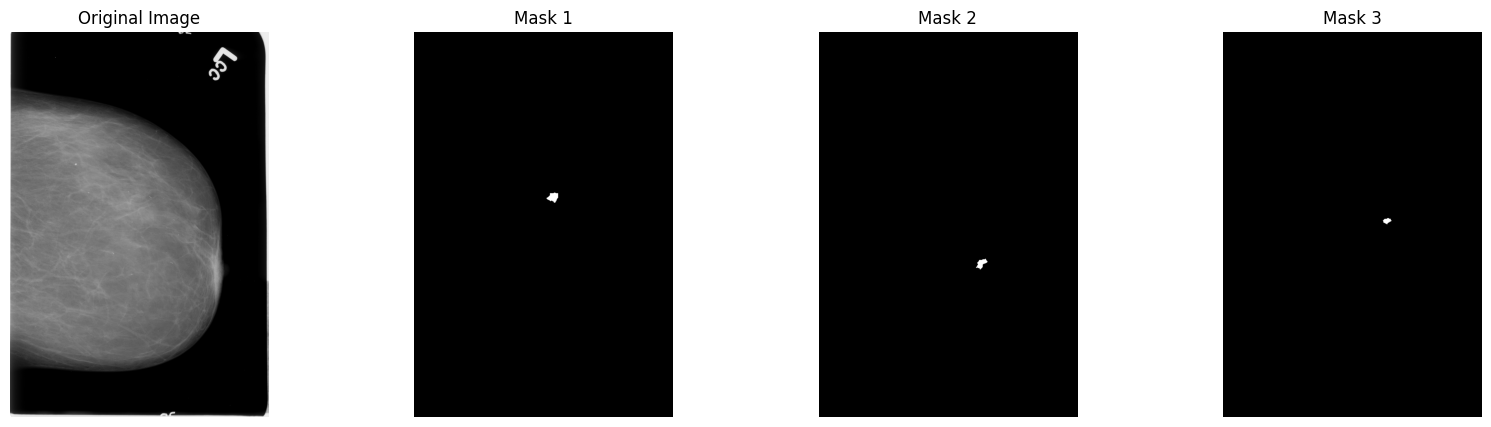

In [6]:
image = plt.imread(os.path.join(train_images_path, image_path))

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(image, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")
for i, path in enumerate(mask_paths):
    masks = plt.imread(path)
    axes[i + 1].imshow(masks, cmap="gray")
    axes[i + 1].set_title(f"Mask {i+1}")
    axes[i + 1].axis("off")
plt.show()

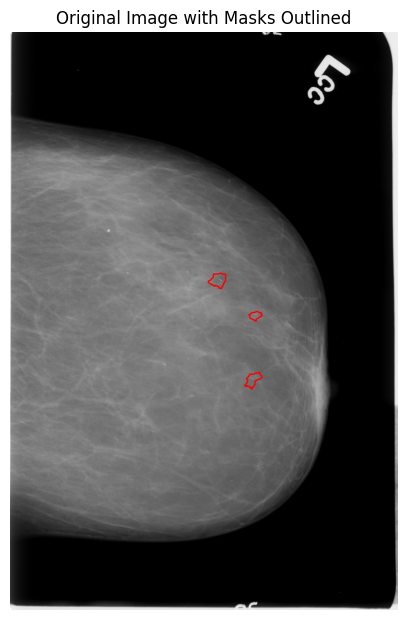

In [7]:
from skimage import measure

fig, ax = plt.subplots(figsize=(5, 10))
ax.imshow(image, cmap="gray")
ax.set_title("Original Image with Masks Outlined")
ax.axis("off")

for path in mask_paths:
    mask = plt.imread(path)
    contours = measure.find_contours(mask, 0.5)
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color="red")

plt.show()

In [8]:
image2_path = train_images_filenames[1]
image2 = plt.imread(os.path.join(train_images_path, image2_path))

print(f"Image shape: {image.shape}")
print(f"Image min value: {image.min()}")
print(f"Image max value: {image.max()}")
print(f"Image mean value: {image.mean()}")
print()
print(f"Image2 shape: {image2.shape}")
print(f"Image2 min value: {image2.min()}")
print(f"Image2 max value: {image2.max()}")
print(f"Image2 mean value: {image2.mean()}")

Image shape: (4568, 3064)
Image min value: 0.0
Image max value: 1.0
Image mean value: 0.2410660684108734

Image2 shape: (6346, 2911)
Image2 min value: 0.0
Image2 max value: 1.0
Image2 mean value: 0.22830073535442352


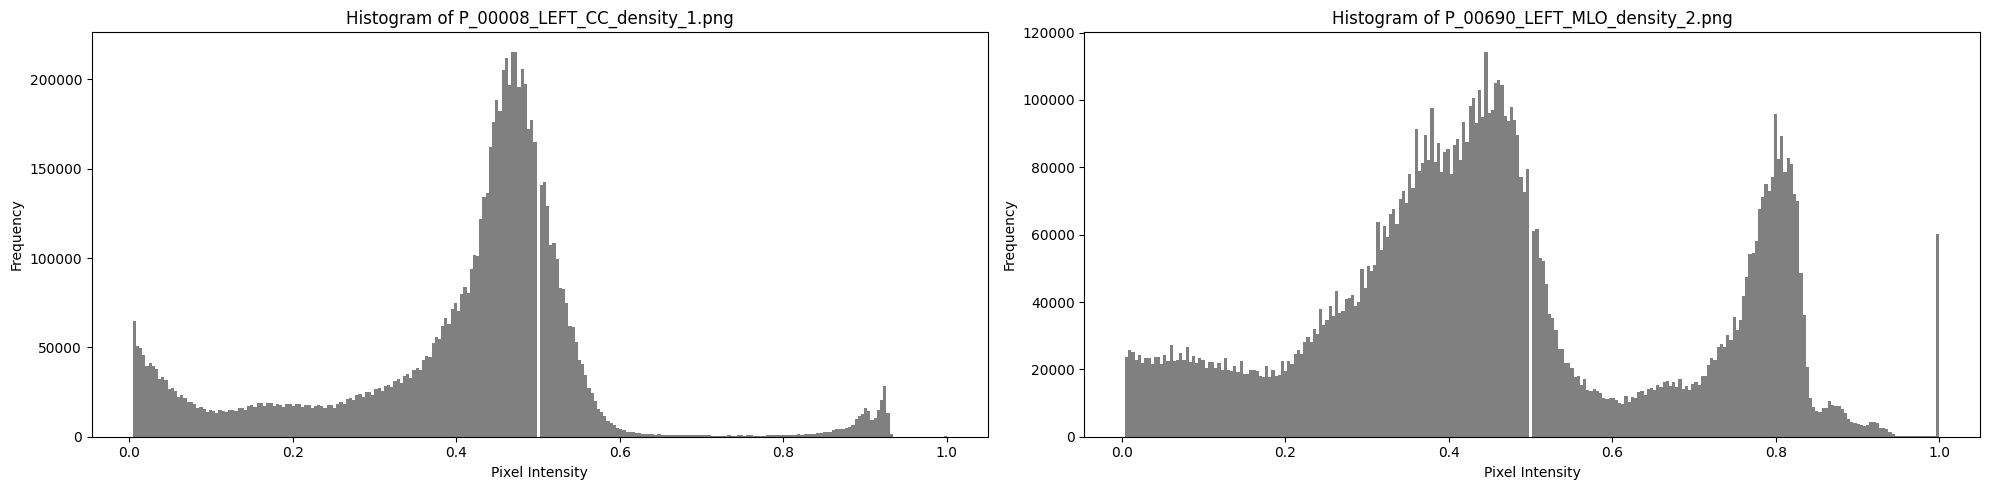

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.hist(image[image > 0].ravel(), bins=256, color="gray")
ax1.set_title(f"Histogram of {image_path}")
ax1.set_xlabel("Pixel Intensity")
ax1.set_ylabel("Frequency")

ax2.hist(image2[image2 > 0].ravel(), bins=256, color="gray")
ax2.set_title(f"Histogram of {image2_path}")
ax2.set_xlabel("Pixel Intensity")
ax2.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

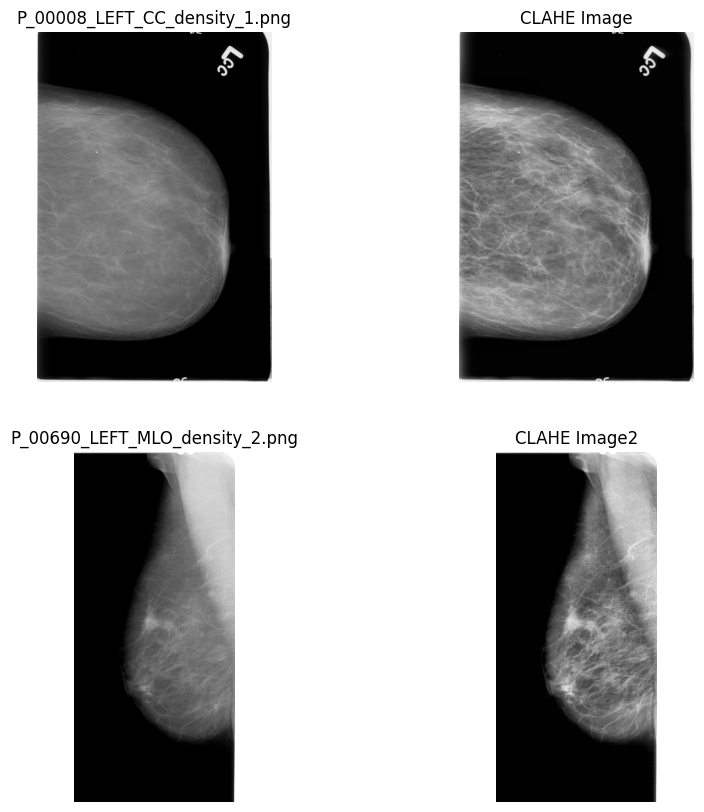

In [10]:
import cv2

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

image_clahe = clahe.apply((image * 255).astype(np.uint8))
image2_clahe = clahe.apply((image2 * 255).astype(np.uint8))

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].imshow(image, cmap="gray")
axes[0, 0].set_title(f"{image_path}")
axes[0, 0].axis("off")

axes[0, 1].imshow(image_clahe, cmap="gray")
axes[0, 1].set_title("CLAHE Image")
axes[0, 1].axis("off")

axes[1, 0].imshow(image2, cmap="gray")
axes[1, 0].set_title(f"{image2_path}")
axes[1, 0].axis("off")

axes[1, 1].imshow(image2_clahe, cmap="gray")
axes[1, 1].set_title("CLAHE Image2")
axes[1, 1].axis("off")

plt.show()

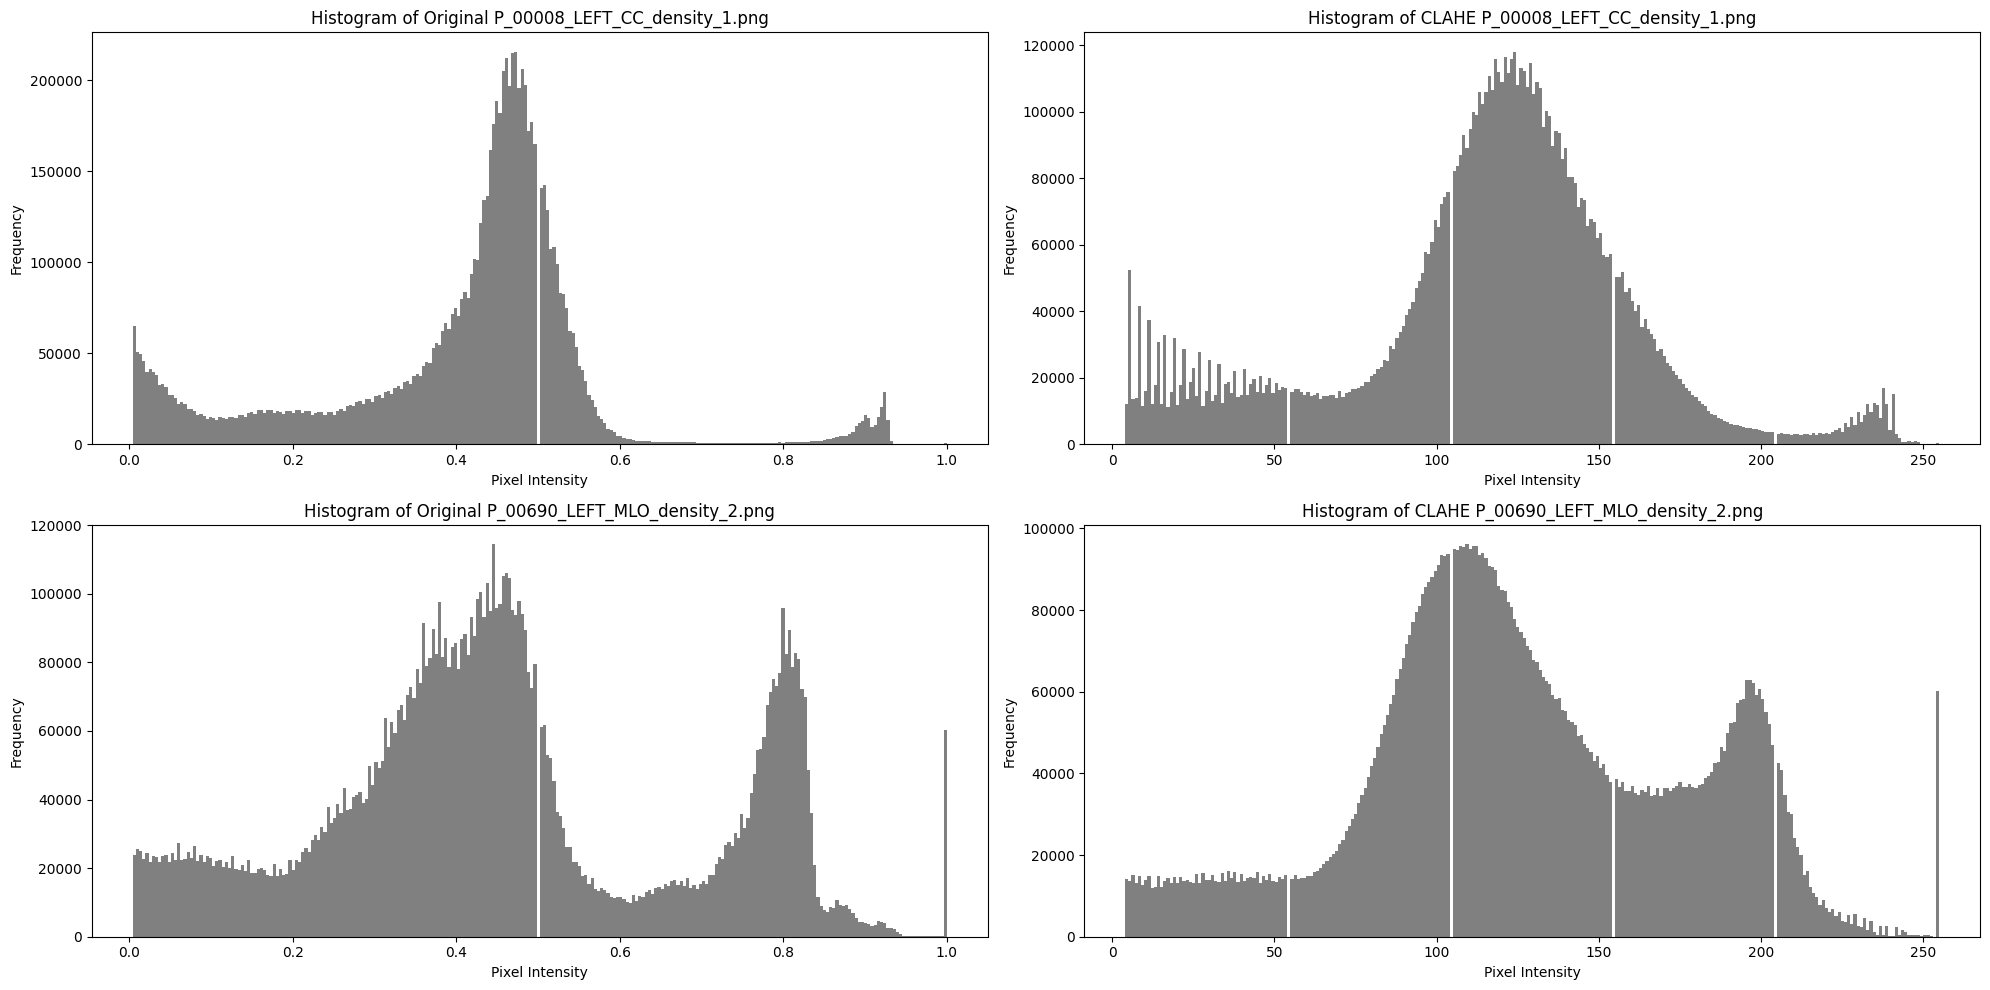

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# Histogram of the original image
axes[0, 0].hist(image[image > 0].ravel(), bins=256, color="gray")
axes[0, 0].set_title(f"Histogram of Original {image_path}")
axes[0, 0].set_xlabel("Pixel Intensity")
axes[0, 0].set_ylabel("Frequency")

# Histogram of the CLAHE image
axes[0, 1].hist(image_clahe[image_clahe > 3].ravel(), bins=256, color="gray")
axes[0, 1].set_title(f"Histogram of CLAHE {image_path}")
axes[0, 1].set_xlabel("Pixel Intensity")
axes[0, 1].set_ylabel("Frequency")

# Histogram of the second original image
axes[1, 0].hist(image2[image2 > 0].ravel(), bins=256, color="gray")
axes[1, 0].set_title(f"Histogram of Original {image2_path}")
axes[1, 0].set_xlabel("Pixel Intensity")
axes[1, 0].set_ylabel("Frequency")

# Histogram of the second CLAHE image
axes[1, 1].hist(image2_clahe[image2_clahe > 3].ravel(), bins=256, color="gray")
axes[1, 1].set_title(f"Histogram of CLAHE {image2_path}")
axes[1, 1].set_xlabel("Pixel Intensity")
axes[1, 1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

Training Data Counts:
  Type  Density  Count
0   CC        1    163
1  MLO        1    182
2   CC        2    429
3  MLO        2    466
4   CC        3    340
5  MLO        3    374
6   CC        4    181
7  MLO        4    218

Test Data Counts:
  Type  Density  Count
0   CC        1     29
1  MLO        1     36
2   CC        2    117
3  MLO        2    138
4   CC        3     93
5  MLO        3    100
6   CC        4     50
7  MLO        4     62


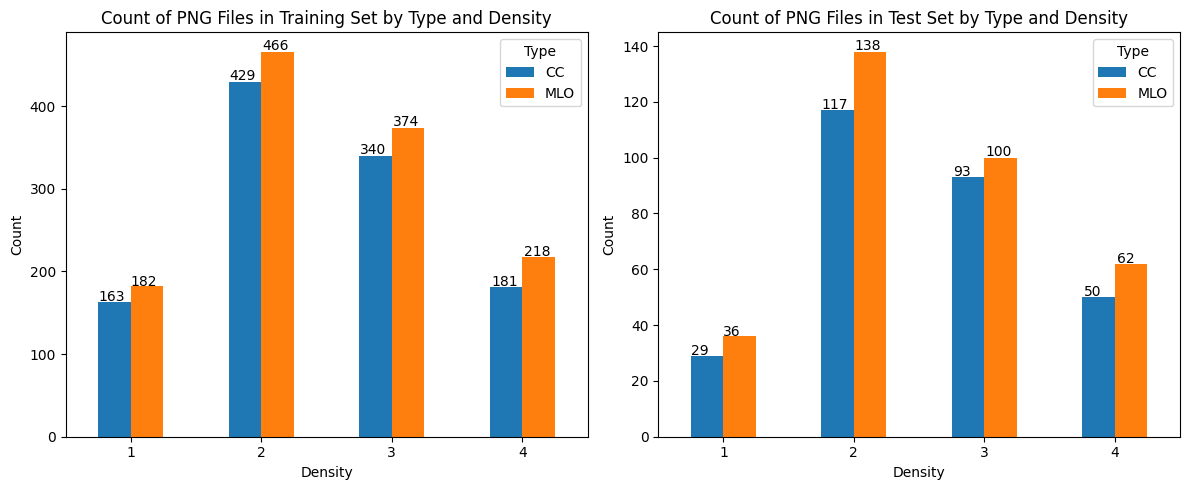

In [12]:
import pandas as pd

data_train = {"Type": [], "Density": [], "Count": []}
data_test = {"Type": [], "Density": [], "Count": []}

for density in range(1, 5):
    for type in ["CC", "MLO"]:
        count_train = sum(
            1
            for filename in train_images_filenames
            if f"{type}_density_{density}" in filename
        )
        data_train["Type"].append(type)
        data_train["Density"].append(density)
        data_train["Count"].append(count_train)

    for type in ["CC", "MLO"]:
        count_test = sum(
            1
            for filename in test_images_filenames
            if f"{type}_density_{density}" in filename
        )
        data_test["Type"].append(type)
        data_test["Density"].append(density)
        data_test["Count"].append(count_test)

df_counts_train = pd.DataFrame(data_train)
df_counts_test = pd.DataFrame(data_test)

print("Training Data Counts:")
print(df_counts_train)
print("\nTest Data Counts:")
print(df_counts_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax_train = axes[0]
df_counts_train.pivot(index="Density", columns="Type", values="Count").plot(
    kind="bar", ax=ax_train
)
ax_train.set_title("Count of PNG Files in Training Set by Type and Density")
ax_train.set_xlabel("Density")
ax_train.set_ylabel("Count")
ax_train.set_xticklabels(ax_train.get_xticklabels(), rotation=0)

for p in ax_train.patches:
    ax_train.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

ax_test = axes[1]
df_counts_test.pivot(index="Density", columns="Type", values="Count").plot(
    kind="bar", ax=ax_test
)
ax_test.set_title("Count of PNG Files in Test Set by Type and Density")
ax_test.set_xlabel("Density")
ax_test.set_ylabel("Count")
ax_test.set_xticklabels(ax_test.get_xticklabels(), rotation=0)

for p in ax_test.patches:
    ax_test.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.tight_layout()
plt.show()

In [13]:
def get_density_images(density, type, num_images=10):
    density_images = [
        f for f in train_images_filenames if f.endswith(f"{type}_density_{density}.png")
    ]
    if len(density_images) < num_images:
        return density_images
    return density_images[:num_images]


def compute_average_histogram(images):
    histograms = []
    for image_path in images:
        image = plt.imread(os.path.join(train_images_path, image_path))
        hist, _ = np.histogram(image[image > 0].ravel(), bins=256, range=(0, 1))
        histograms.append(hist)
    average_histogram = np.mean(histograms, axis=0)
    return average_histogram

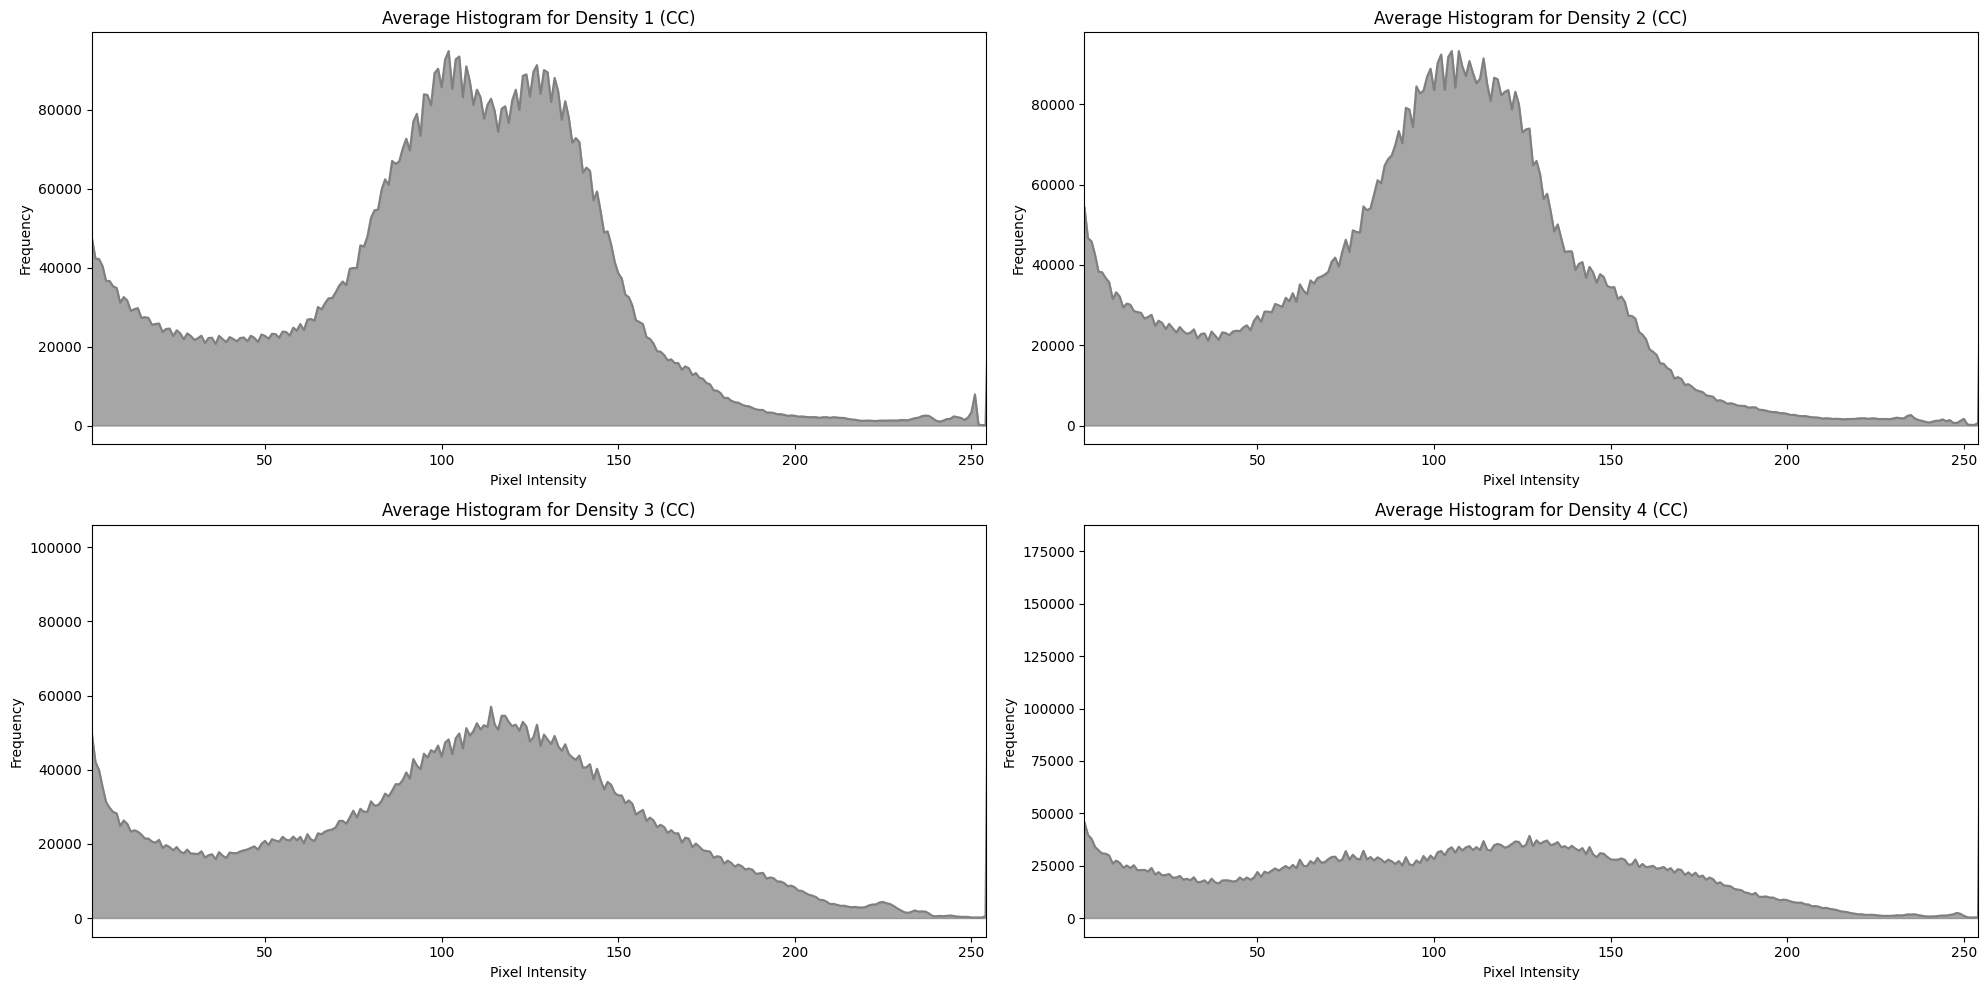

In [14]:
densities = [1, 2, 3, 4]
average_histograms = {}

for density in densities:
    images = get_density_images(density, "CC", 50)
    average_histograms[density] = compute_average_histogram(images)

fig, axes = plt.subplots(2, 2, figsize=(20, 10))

for i, density in enumerate(densities):
    ax = axes[i // 2, i % 2]
    ax.plot(average_histograms[density], color="gray")
    ax.set_title(f"Average Histogram for Density {density} (CC)")
    ax.set_xlabel("Pixel Intensity")
    ax.set_ylabel("Frequency")
    ax.set_xlim([1, 254])
    ax.fill_between(range(0, 256), average_histograms[density], color="gray", alpha=0.7)

plt.tight_layout()
plt.show()

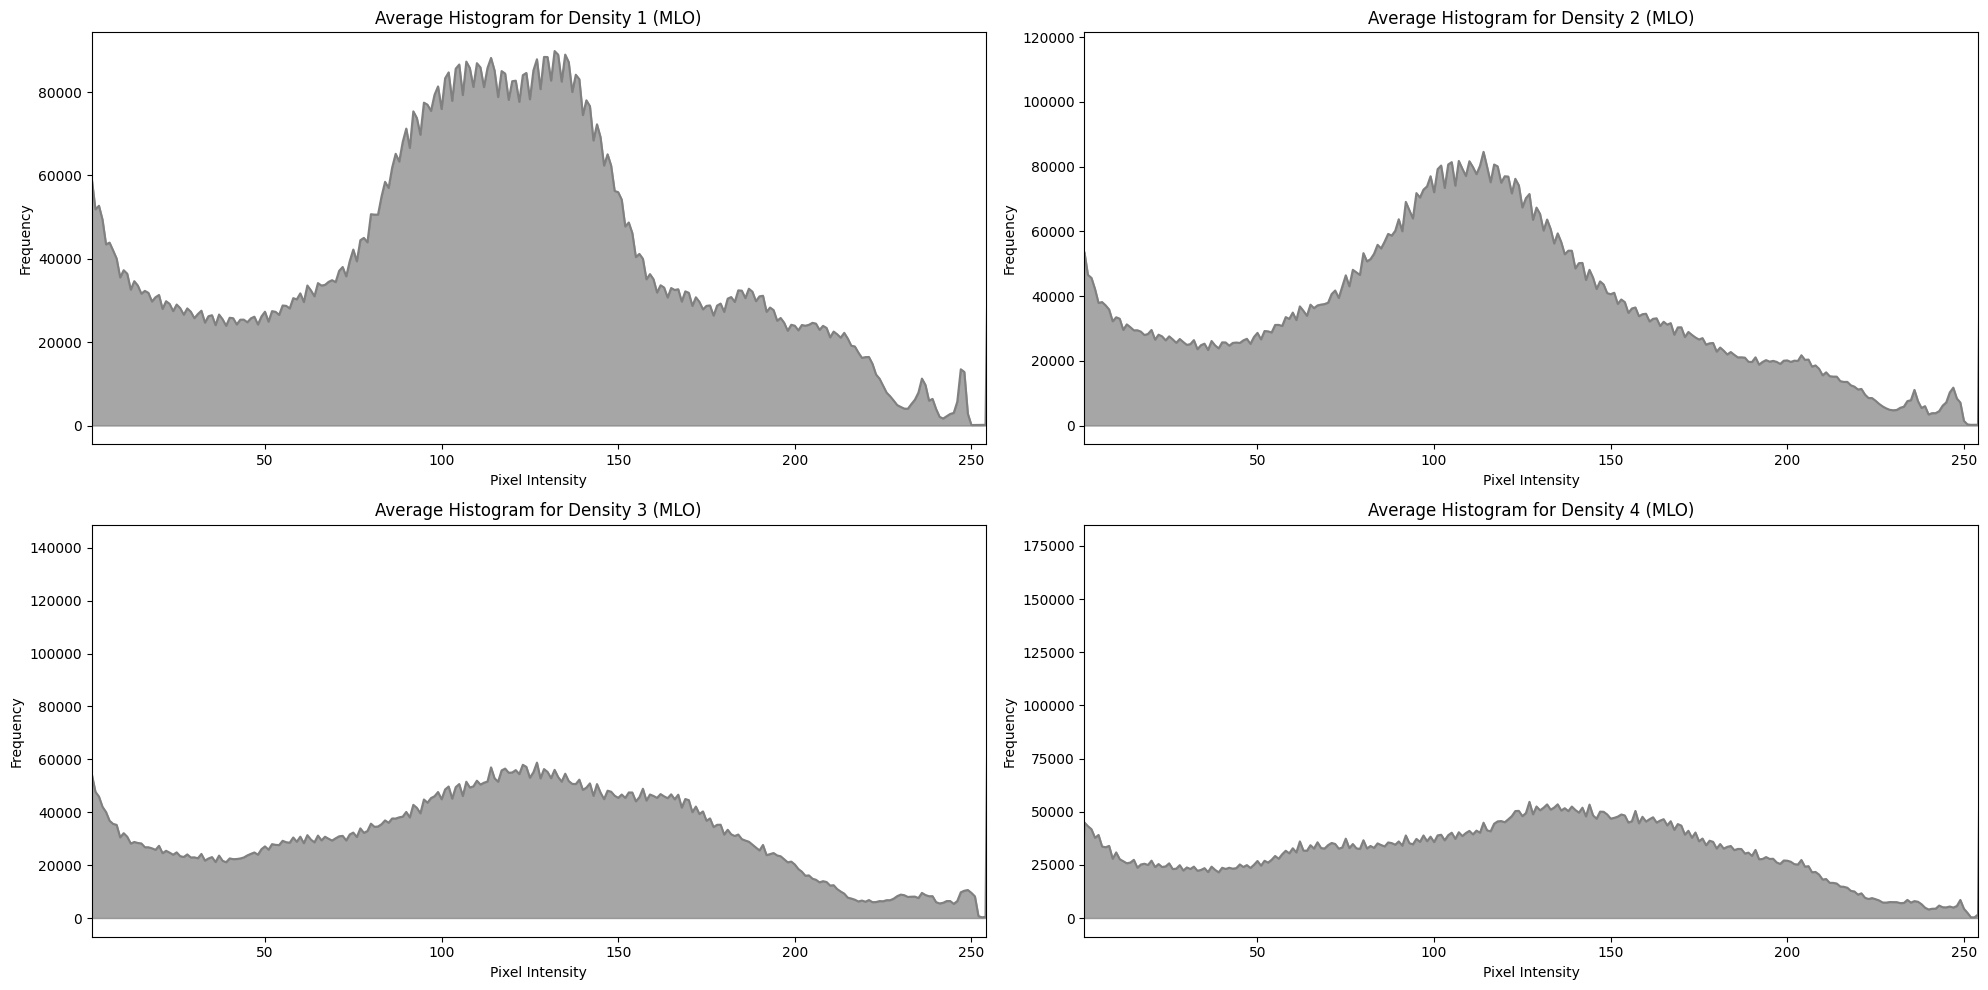

In [15]:
densities = [1, 2, 3, 4]
average_histograms = {}

for density in densities:
    images = get_density_images(density, "MLO", 50)
    average_histograms[density] = compute_average_histogram(images)

fig, axes = plt.subplots(2, 2, figsize=(20, 10))

for i, density in enumerate(densities):
    ax = axes[i // 2, i % 2]
    ax.plot(average_histograms[density], color="gray")
    ax.set_title(f"Average Histogram for Density {density} (MLO)")
    ax.set_xlabel("Pixel Intensity")
    ax.set_ylabel("Frequency")
    ax.set_xlim([1, 254])
    ax.fill_between(range(0, 256), average_histograms[density], color="gray", alpha=0.7)

plt.tight_layout()
plt.show()